In [ ]:
import numpy as np
import lightkurve as lk
from lightkurve.correctors import load_kepler_cbvs
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
import pickle
from astropy.io import fits
from tqdm import tqdm
import warnings
from lightkurve import search_targetpixelfile, download_kepler_cbvs
from scipy import stats

In [25]:
# get metadata for this star, can use "nearby stars" in general since not all stars have kepler LCs
# but all cluster stars are close by so SHOULD be the same?
# can also search metadata here: https://archive.stsci.edu/kepler/data_search/search.php
example = lk.search_lightcurve('KIC 4936741', author='Kepler', quarter='4').download()
example.hdu[0].header

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27975/2283989847.py:5: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  example.hdu[0].header


SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-12'         / file creation date.                            
CREATOR = '860949 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.22 r60269' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [166]:
kics = pd.read_csv('matching_kic_ids.txt').values
kics = kics[:,0]
import re

def get_url_for_kepler_id(curl_file_path, target_id):
    """
    Extract the URL for a specific Kepler ID from a file containing curl commands.
    
    Args:
        curl_file_path (str): Path to the file containing curl commands
        target_id (str or int): Kepler ID to search for
        
    Returns:
        str: URL for the specified ID, or None if not found
    """
    # Convert target_id to string and remove leading zeros for comparison
    target_id = str(target_id).lstrip('0')
    
    # Read curl commands from file
    with open(curl_file_path, 'r') as file:
        curl_commands = file.read()
    
    # Define regex pattern to extract ID and URL from curl commands
    pattern = r'kplr(\d+)-q\d+.*?"(https://mast\.stsci\.edu/api/v0\.1/Download/file/\?&uri=mast:HLSP/iris/\d+/\d+/.*?)"'
    
    # Find all matches in the curl commands
    matches = re.findall(pattern, curl_commands)
    
    # Search for matching ID and return the URL
    for kepler_id, url in matches:
        if kepler_id.lstrip('0') == target_id:
            return url
    
    return None

In [167]:
quarter = 3
url = get_url_for_kepler_id(f"IRIS/ngc6819_q{quarter}_IRIS_lc.sh", kics[2000])

In [168]:
test = fits.open(url)

In [158]:
cadence = test[1].data['CADENCE']
time = test[1].data['TIME']
flux = test[1].data['FLUX']

In [159]:
# https://lightkurve.github.io/lightkurve/tutorials/2-creating-light-curves/2-2-how-to-use-cbvs.html
cbvs = load_kepler_cbvs(mission='Kepler', quarter=quarter, channel=78)

In [161]:
cbv_designmatrix = cbvs.to_designmatrix(cbv_indices=np.arange(1,9), name='10.1.1.SingleScale')
cbv_designmatrix

10.1.1.SingleScale DesignMatrix (4370, 8)

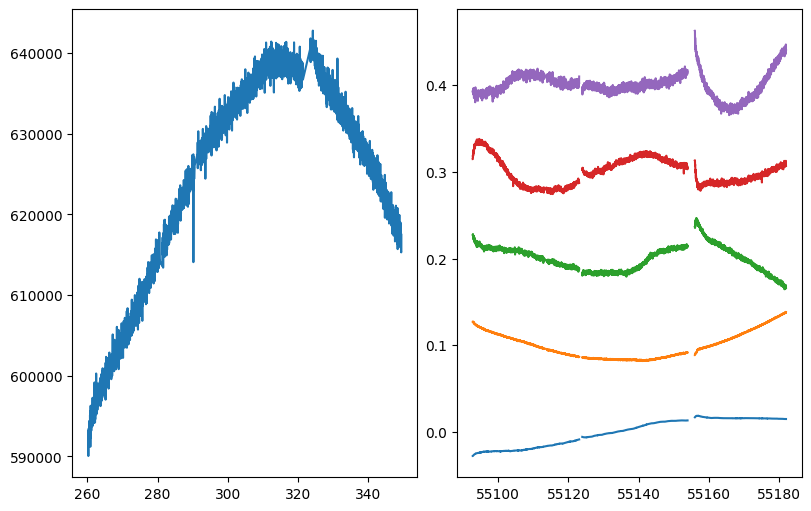

In [163]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(8,5))

ax[0].plot(time, flux)

for i in range(5):
    ax[1].plot(cbvs['time'].value, cbvs[f'VECTOR_{i+1}'].value+0.1*i)

Calculated time offset: 54830.60
Light curve time range (adjusted): 55090.82 to 55180.09
CBVs time range: 51544.50 to 55182.00
Found 3921 valid time matches with tolerance 0.02 days.
CBV Coefficients:
CBV 1: 599941.816714
CBV 2: -522363.080161
CBV 3: -31131.404828
CBV 4: -20984.017626
CBV 5: -21.463267
CBV 6: 4332.130428
CBV 7: 7746.858916
CBV 8: 333.590733
Average time match quality: 1.55 minutes


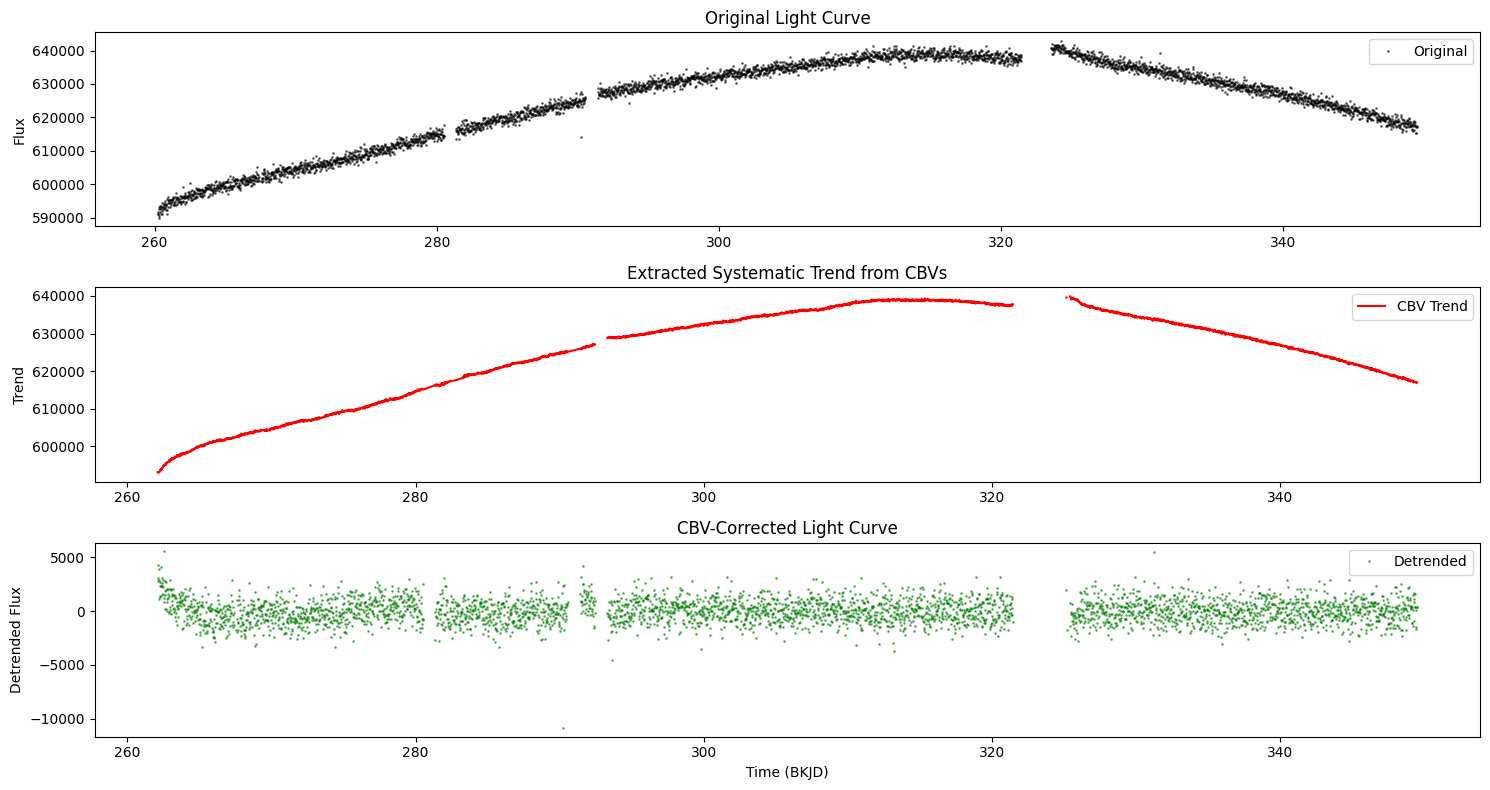

In [ ]:
def detrend_with_shifted_cbvs(time, flux, cbvs, cbv_indices=None, time_tolerance=0.02):
    """
    Detrend a light curve using Kepler CBVs with automatic time scale alignment
    
    Parameters:
    -----------
    time : array-like
        Time array for the light curve
    flux : array-like
        Flux array to detrend
    cbvs : Table/DataFrame
        CBVs table with columns 'time', 'VECTOR_1', 'VECTOR_2', etc.
    cbv_indices : list, optional
        Indices of CBVs to use, default: [1,2,3,4,5,6,7,8]
    time_tolerance : float, optional
        Maximum time difference (in days) to consider a match after adjustment
    
    Returns:
    --------
    corrected_flux : array-like
        Detrended flux
    trend : array-like
        The trend that was removed
    model : LinearRegression
        The fitted model
    """
    # Default to using CBVs 1-8 if not specified
    if cbv_indices is None:
        cbv_indices = list(range(1, 9))
    
    # Filter out NaNs in the flux data
    mask = ~np.isnan(flux)
    clean_time = time[mask]
    clean_flux = flux[mask]
    
    # Get time values from CBVs
    try:
        cbv_time = cbvs['time'].value
    except AttributeError:
        cbv_time = cbvs['time']
    
    # Convert to float arrays for safety
    clean_time = np.array(clean_time, dtype=float)
    cbv_time = np.array(cbv_time, dtype=float)
    
    # Calculate the time offset between the two datasets
    time_offset = np.median(cbv_time) - np.median(clean_time)
    print(f"Calculated time offset: {time_offset:.2f}")
    
    # Adjust the light curve time by the offset for matching
    adjusted_time = clean_time + time_offset
    
    # Check for overlap after adjustment
    print(f"Light curve time range (adjusted): {min(adjusted_time):.2f} to {max(adjusted_time):.2f}")
    print(f"CBVs time range: {min(cbv_time):.2f} to {max(cbv_time):.2f}")
    
    # Prepare matrices for the model
    X = np.zeros((len(clean_time), len(cbv_indices)))
    valid_indices = []
    match_quality = []
    
    # For each time point in our adjusted light curve, find the closest time in CBVs
    for i, t in enumerate(adjusted_time):
        # Find closest time point in CBVs
        distances = np.abs(cbv_time - t)
        closest_idx = np.argmin(distances)
        
        # Only use if the times are close enough
        if distances[closest_idx] <= time_tolerance:
            # Extract the CBV vectors for this time
            row_valid = True
            for j, vec_idx in enumerate(cbv_indices):
                vector_name = f'VECTOR_{vec_idx}'
                try:
                    cbv_value = cbvs[vector_name][closest_idx]
                    
                    # Check if the CBV value is valid
                    if np.isnan(cbv_value):
                        row_valid = False
                        break
                    
                    X[i, j] = cbv_value
                except (KeyError, IndexError):
                    print(f"Error accessing {vector_name} at index {closest_idx}")
                    row_valid = False
                    break
            
            if row_valid:
                valid_indices.append(i)
                match_quality.append(distances[closest_idx])
    
    valid_indices = np.array(valid_indices)
    print(f"Found {len(valid_indices)} valid time matches with tolerance {time_tolerance} days.")
    
    if len(valid_indices) < 10 and time_tolerance < 1.0:
        # If too few matches, try with a larger tolerance
        larger_tolerance = time_tolerance * 5
        print(f"Too few matches. Trying with larger tolerance of {larger_tolerance} days...")
        return detrend_with_shifted_cbvs(time, flux, cbvs, cbv_indices, larger_tolerance)
    
    if len(valid_indices) == 0:
        print("ERROR: No valid time matches found after time adjustment.")
        return None, None, None
    
    # Get valid data for model fitting
    X_valid = X[valid_indices]
    valid_fluxes = clean_flux[valid_indices]
    
    # Fit the linear model
    model = LinearRegression()
    model.fit(X_valid, valid_fluxes)
    
    # Calculate the trend for matched time points
    trend_clean = np.full_like(clean_flux, np.nan)
    predicted_values = model.predict(X_valid)
    trend_clean[valid_indices] = predicted_values
    
    # Apply the correction
    corrected_flux_clean = np.full_like(clean_flux, np.nan)
    corrected_flux_clean[valid_indices] = valid_fluxes - predicted_values
    
    # Map back to original arrays
    trend_full = np.full_like(flux, np.nan)
    corrected_flux = np.full_like(flux, np.nan)
    
    # Fill in the values
    clean_indices = np.where(mask)[0]
    for i, idx in enumerate(valid_indices):
        orig_idx = clean_indices[idx]
        trend_full[orig_idx] = trend_clean[idx]
        corrected_flux[orig_idx] = clean_flux[idx] - trend_clean[idx]
    
    # Print the CBV coefficients
    print("CBV Coefficients:")
    for i, coef in enumerate(model.coef_):
        print(f"CBV {cbv_indices[i]}: {coef:.6f}")
    
    # Calculate average time match quality
    avg_match = np.mean(match_quality) * 24 * 60  # Convert to minutes
    print(f"Average time match quality: {avg_match:.2f} minutes")
    
    return corrected_flux, trend_full, model

# Apply the detrending with automatic time scale alignment
cbv_indices = list(range(1, 9))  # Using CBVs 1-8
corrected_flux, trend, model = detrend_with_shifted_cbvs(time, flux, cbvs, cbv_indices)

# Check if detrending was successful
if corrected_flux is not None:
    # Plot the results
    plt.figure(figsize=(15, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time, flux, 'k.', alpha=0.5, markersize=2, label='Original')
    plt.ylabel('Flux')
    plt.legend()
    plt.title('Original Light Curve')

    plt.subplot(3, 1, 2)
    plt.plot(time, trend, 'r-', label='CBV Trend')
    plt.ylabel('Trend')
    plt.legend()
    plt.title('Extracted Systematic Trend from CBVs')

    plt.subplot(3, 1, 3)
    plt.plot(time, corrected_flux, 'g.', alpha=0.5, markersize=2, label='Detrended')
    plt.xlabel('Time (BKJD)')
    plt.ylabel('Detrended Flux')
    plt.legend()
    plt.title('CBV-Corrected Light Curve')

    plt.tight_layout()
    plt.show()
else:
    print("Detrending failed. Check the diagnostic information above.")

In [ ]:
def process_all_stars_all_quarters(kics, output_dir="CBV_kepler_detrended", max_quarter=17, channel=78):
    """
    Process all stars for all available quarters and save results
    
    Parameters:
    -----------
    kics : array-like
        Array of Kepler IDs
    output_dir : str
        Directory to save results
    max_quarter : int
        Maximum quarter to process
    channel : int
        Channel number for CBVs
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each quarter
    for quarter in range(1, max_quarter + 1):
        print(f"\nProcessing Quarter {quarter}...")
        
        # Try to load CBVs for this quarter
        try:
            cbvs = download_kepler_cbvs(mission='Kepler', quarter=quarter, channel=channel)
            print(f"Successfully loaded CBVs for Q{quarter}")
        except Exception as e:
            print(f"Could not load CBVs for Q{quarter}: {e}")
            continue  # Skip this quarter if CBVs can't be loaded
        
        # Prepare a dictionary to store results for this quarter
        quarter_results = {}
        
        # Process each star
        for i, kic in enumerate(tqdm(kics, desc=f"Processing stars for Q{quarter}")):
            try:
                # Get light curve data for this star and quarter
                url = get_url_for_kepler_id(f"IRIS/ngc6819_q{quarter}_IRIS_lc.sh", kic)
                
                try:
                    hdul = fits.open(url)
                    
                    # Extract data
                    cadence = hdul[1].data['CADENCE']
                    time = hdul[1].data['TIME']
                    flux = hdul[1].data['FLUX']
                    
                    # Check if we have enough valid data points
                    if np.sum(~np.isnan(flux)) < 10:
                        hdul.close()
                        continue  # Skip if not enough valid data
                    
                    # Detrend the light curve
                    cbv_indices = list(range(1, 9))  # Using CBVs 1-8
                    corrected_flux, trend, model = detrend_with_shifted_cbvs(time, flux, cbvs, cbv_indices)
                    
                    # Store results if detrending was successful
                    if corrected_flux is not None:
                        quarter_results[kic] = {
                            'time': time,
                            'flux_original': flux,
                            'flux_corrected': corrected_flux,
                            'trend': trend,
                            'cadence': cadence
                        }
                    
                    hdul.close()
                
                except Exception as e:
                    # Handle case where data isn't available for this star/quarter
                    pass
            
            except Exception as e:
                print(f"Error processing KIC {kic} in quarter {quarter}: {e}")
        
        # Save results for this quarter if we have any
        if quarter_results:
            output_file = os.path.join(output_dir, f"ngc6819_detrend_q{quarter}_kepler.pkl")
            with open(output_file, 'wb') as f:
                pickle.dump(quarter_results, f)
            print(f"Saved results for {len(quarter_results)} stars in Q{quarter} to {output_file}")
        else:
            print(f"No valid results for Q{quarter}")


process_all_stars_all_quarters(kics, output_dir="CBV_kepler_detrended", max_quarter=17, channel=78)
    
# process_all_stars_all_quarters(kics[:10], output_dir="CBV_kepler_detrended_test", max_quarter=3)


Processing Quarter 1...
Successfully loaded CBVs for Q1


Processing stars for Q1: 100%|██████████| 2205/2205 [05:58<00:00,  6.15it/s]


Saved results for 2205 stars in Q1 to CBV_kepler_detrended/ngc6819_detrend_q1_kepler.pkl

Processing Quarter 2...
Successfully loaded CBVs for Q2


Processing stars for Q2: 100%|██████████| 2205/2205 [11:42<00:00,  3.14it/s]


Saved results for 2169 stars in Q2 to CBV_kepler_detrended/ngc6819_detrend_q2_kepler.pkl

Processing Quarter 3...
Successfully loaded CBVs for Q3


Processing stars for Q3: 100%|██████████| 2205/2205 [11:59<00:00,  3.06it/s]


Saved results for 2163 stars in Q3 to CBV_kepler_detrended/ngc6819_detrend_q3_kepler.pkl

Processing Quarter 4...
Successfully loaded CBVs for Q4


Processing stars for Q4: 100%|██████████| 2205/2205 [11:59<00:00,  3.07it/s]


Saved results for 2177 stars in Q4 to CBV_kepler_detrended/ngc6819_detrend_q4_kepler.pkl

Processing Quarter 5...
Successfully loaded CBVs for Q5


Processing stars for Q5: 100%|██████████| 2205/2205 [12:35<00:00,  2.92it/s]


Saved results for 2203 stars in Q5 to CBV_kepler_detrended/ngc6819_detrend_q5_kepler.pkl

Processing Quarter 6...
Successfully loaded CBVs for Q6


Processing stars for Q6: 100%|██████████| 2205/2205 [00:00<00:00, 48527.61it/s]

No valid results for Q6

Processing Quarter 7...


Successfully loaded CBVs for Q7


Processing stars for Q7: 100%|██████████| 2205/2205 [12:03<00:00,  3.05it/s]


Saved results for 2162 stars in Q7 to CBV_kepler_detrended/ngc6819_detrend_q7_kepler.pkl

Processing Quarter 8...
Successfully loaded CBVs for Q8


Processing stars for Q8: 100%|██████████| 2205/2205 [09:40<00:00,  3.80it/s]


Saved results for 2176 stars in Q8 to CBV_kepler_detrended/ngc6819_detrend_q8_kepler.pkl

Processing Quarter 9...
Successfully loaded CBVs for Q9


Processing stars for Q9: 100%|██████████| 2205/2205 [13:17<00:00,  2.77it/s]


Saved results for 2204 stars in Q9 to CBV_kepler_detrended/ngc6819_detrend_q9_kepler.pkl

Processing Quarter 10...
Successfully loaded CBVs for Q10


Processing stars for Q10: 100%|██████████| 2205/2205 [00:00<00:00, 48912.07it/s]

No valid results for Q10

Processing Quarter 11...


Successfully loaded CBVs for Q11


Processing stars for Q11: 100%|██████████| 2205/2205 [12:22<00:00,  2.97it/s]


Saved results for 2163 stars in Q11 to CBV_kepler_detrended/ngc6819_detrend_q11_kepler.pkl

Processing Quarter 12...
Successfully loaded CBVs for Q12


Processing stars for Q12: 100%|██████████| 2205/2205 [10:46<00:00,  3.41it/s]


Saved results for 2178 stars in Q12 to CBV_kepler_detrended/ngc6819_detrend_q12_kepler.pkl

Processing Quarter 13...
Successfully loaded CBVs for Q13


Processing stars for Q13: 100%|██████████| 2205/2205 [12:14<00:00,  3.00it/s]


Saved results for 2203 stars in Q13 to CBV_kepler_detrended/ngc6819_detrend_q13_kepler.pkl

Processing Quarter 14...
Successfully loaded CBVs for Q14


Processing stars for Q14: 100%|██████████| 2205/2205 [00:00<00:00, 49769.89it/s]

No valid results for Q14

Processing Quarter 15...


Successfully loaded CBVs for Q15


Processing stars for Q15: 100%|██████████| 2205/2205 [11:59<00:00,  3.06it/s]


Saved results for 2161 stars in Q15 to CBV_kepler_detrended/ngc6819_detrend_q15_kepler.pkl

Processing Quarter 16...
Successfully loaded CBVs for Q16


Processing stars for Q16: 100%|██████████| 2205/2205 [09:42<00:00,  3.79it/s]


Saved results for 2178 stars in Q16 to CBV_kepler_detrended/ngc6819_detrend_q16_kepler.pkl

Processing Quarter 17...
Successfully loaded CBVs for Q17


Processing stars for Q17: 100%|██████████| 2205/2205 [02:10<00:00, 16.88it/s]


Saved results for 2203 stars in Q17 to CBV_kepler_detrended/ngc6819_detrend_q17_kepler.pkl


In [174]:
with open('CBV_kepler_detrended/ngc6819_detrend_q1_kepler.pkl', 'rb') as f:
        quarter_data = pickle.load(f)

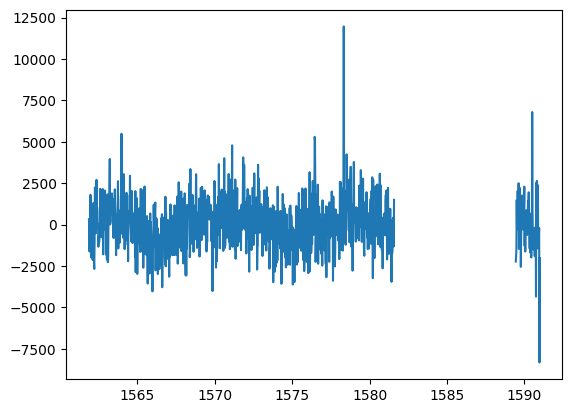

In [181]:
plt.plot(quarter_data[4936771]['time'], quarter_data[4936771]['flux_corrected'])

In [ ]:
base_dir = 'CBV_kepler_detrended'
quarters = [1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]  

def clean_light_curves(flux, time, sigma_threshold=50.0, max_iterations=3):
    """
    Remove outliers from light curve data using sigma clipping
    
    Parameters:
    -----------
    flux : array-like
        Flux measurements
    time : array-like
        Time measurements corresponding to flux
    sigma_threshold : float
        Number of standard deviations for outlier detection
    max_iterations : int
        Maximum number of iterations for sigma clipping
    
    Returns:
    --------
    cleaned_flux : array-like
        Flux with outliers replaced by NaN
    cleaned_time : array-like
        Corresponding time array
    """
    # Make copies to avoid modifying original data
    cleaned_flux = np.copy(flux)
    cleaned_time = np.copy(time)
    
    # Handle NaN values
    valid_mask = ~np.isnan(cleaned_flux)
    
    if np.sum(valid_mask) < 10:
        return cleaned_flux, cleaned_time  # Not enough data points
    
    valid_flux = cleaned_flux[valid_mask]
    
    # Iterative sigma clipping
    for _ in range(max_iterations):
        # Calculate median and standard deviation of valid points
        median = np.median(valid_flux)
        std = np.std(valid_flux)
        
        # Find points that are too far from median
        outlier_mask = np.abs(valid_flux - median) > sigma_threshold * std
        
        if not np.any(outlier_mask):
            break  # No more outliers
        
        # Replace outliers with NaN in the full array
        outlier_indices = np.where(valid_mask)[0][outlier_mask]
        cleaned_flux[outlier_indices] = np.nan
        
        # Update valid mask and valid flux for next iteration
        valid_mask = ~np.isnan(cleaned_flux)
        valid_flux = cleaned_flux[valid_mask]
    
    return cleaned_flux, cleaned_time

def normalize_quarter_flux(flux, method='median'):
    """
    Normalize flux values within a quarter to account for different flux scales
    
    Parameters:
    -----------
    flux : array-like
        Flux values to normalize
    method : str
        Normalization method ('median', 'mean', or 'minmax')
    
    Returns:
    --------
    normalized_flux : array-like
        Normalized flux values
    """
    valid_mask = ~np.isnan(flux)
    if np.sum(valid_mask) < 5:
        return flux  # Not enough valid points
    
    normalized_flux = np.copy(flux)
    
    if method == 'median':
        # Normalize by dividing by median and subtracting 1
        median = np.median(flux[valid_mask])
        normalized_flux[valid_mask] = (flux[valid_mask] / median) - 1
    
    elif method == 'mean':
        # Normalize by subtracting mean and dividing by standard deviation
        mean = np.mean(flux[valid_mask])
        std = np.std(flux[valid_mask])
        if std > 0:
            normalized_flux[valid_mask] = (flux[valid_mask] - mean) / std
    
    elif method == 'minmax':
        # Normalize to range [0, 1]
        min_val = np.min(flux[valid_mask])
        max_val = np.max(flux[valid_mask])
        if max_val > min_val:
            normalized_flux[valid_mask] = (flux[valid_mask] - min_val) / (max_val - min_val) - 0.5
    
    return normalized_flux

# Process and combine data with outlier removal
combined_data = {}

for quarter in quarters:
    file_path = f"{base_dir}/ngc6819_detrend_q{quarter}_kepler.pkl"
    
    if not os.path.exists(file_path):
        print(f"Skipping Q{quarter}: file not found")
        continue
    
    print(f"Processing Q{quarter}")
    with open(file_path, 'rb') as f:
        quarter_data = pickle.load(f)
    
    for kic_id in quarter_data:
        # Get the data for this star in this quarter
        flux = quarter_data[kic_id]['flux_corrected']
        time = quarter_data[kic_id]['time']
        
        # Skip if not enough valid points
        if np.sum(~np.isnan(flux)) < 10:
            continue
            
        # Remove outliers
        cleaned_flux, cleaned_time = clean_light_curves(flux, time, sigma_threshold=5.0)
        
        # Normalize the flux to make quarters consistent
        normalized_flux = normalize_quarter_flux(cleaned_flux, method='median')
        
        # Initialize star entry in combined data if not already there
        if kic_id not in combined_data:
            combined_data[kic_id] = {'flux': [], 'time': [], 'quarters': []}
        
        combined_data[kic_id]['flux'].append(normalized_flux)
        combined_data[kic_id]['time'].append(cleaned_time)
        combined_data[kic_id]['quarters'].append(quarter)

print(f"Processed data for {len(combined_data)} stars")

# Save combined data
with open('CBV_kepler_detrended/ngc6819_combined_data_cleaned.pkl', 'wb') as f:
    pickle.dump(combined_data, f)
print("Saved cleaned combined data")

Processing Q1
Processing Q2
Processing Q3
Processing Q4
Processing Q5
Processing Q7
Processing Q8
Processing Q9
Processing Q11
Processing Q12
Processing Q13
Processing Q15
Processing Q16
Processing Q17
Processed data for 2205 stars
Saved cleaned combined data


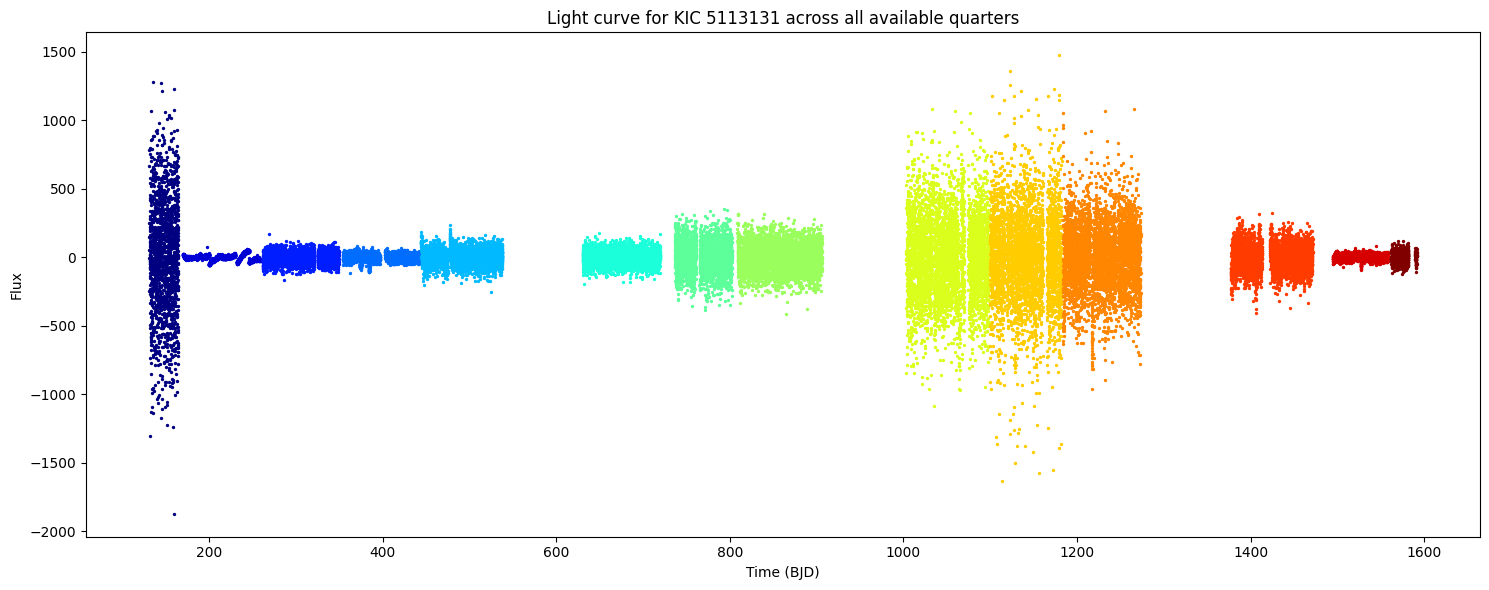

KIC 5113131 has data in 14 quarters: [1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]
Total data points: 52028


In [ ]:
randint = np.random.randint(0,2204)
target_kic = kics[randint]

with open('CBV_kepler_detrended/ngc6819_combined_data_cleaned.pkl', 'rb') as f:
    combined_data = pickle.load(f)

star_data = combined_data[target_kic]
    
plt.figure(figsize=(15, 6))
    
# Create a color map for different quarters
colors = plt.cm.jet(np.linspace(0, 1, len(star_data['quarters'])))

for i, quarter in enumerate(star_data['quarters']):
    flux = star_data['flux'][i]
    times = star_data['time'][i]
    
    plt.scatter(times, flux, s=2, color=colors[i], label=f'Q{quarter}')

plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.title(f'Light curve for KIC {target_kic} across all available quarters')

if len(star_data['quarters']) <= 10:
    plt.legend()

plt.tight_layout()
# plt.ylim(-200,200)
plt.show()

print(f"KIC {target_kic} has data in {len(star_data['quarters'])} quarters: {star_data['quarters']}")
print(f"Total data points: {sum(len(t) for t in star_data['time'])}")

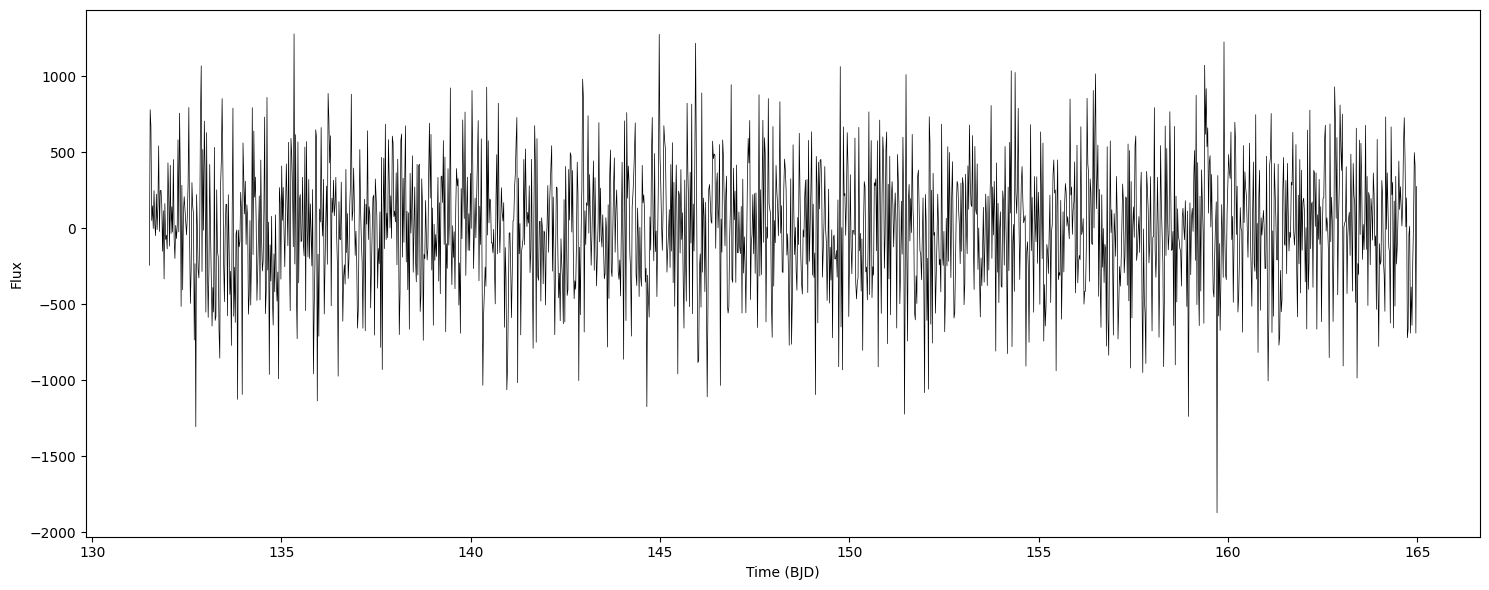

Stitched light curve for KIC 5113131
Total data points: 52028
Time span: 131.51 to 1591.00


In [210]:
star_data = combined_data[target_kic]
    
all_times = []
all_flux = []

for i, quarter in enumerate(star_data['quarters']):
    flux = star_data['flux'][i]
    times = star_data['time'][i]
    
    # Skip if there's no data in this quarter
    if len(flux) == 0:
        continue
    
    # If this is the first quarter with data, use it as the baseline
    if len(all_flux) == 0:
        all_times = list(times)
        all_flux = list(flux)
        baseline_median = np.median(flux)
        continue
    
    # Calculate median flux for this quarter
    quarter_median = np.median(flux)
    
    # Normalize this quarter's flux to match the baseline
    scaling_factor = baseline_median / quarter_median
    adjusted_flux = flux * scaling_factor
        
    # Add this quarter's data to the stitched arrays
    all_times.extend(times)
    all_flux.extend(adjusted_flux)

# Sort the data by time to ensure proper sequence
sorted_indices = np.argsort(all_times)
all_times = np.array(all_times)[sorted_indices]
all_flux = np.array(all_flux)[sorted_indices]

# Plot the stitched light curve
plt.figure(figsize=(15, 6))
plt.plot(all_times, all_flux, 'k-', linewidth=0.5)
# plt.scatter(all_times, all_flux, s=1, c='blue')

plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.tight_layout()
plt.show()

print(f"Stitched light curve for KIC {target_kic}")
print(f"Total data points: {len(all_times)}")
print(f"Time span: {min(all_times):.2f} to {max(all_times):.2f}")

In [212]:
with open('CBV_kepler_detrended/ngc6819_combined_data_cleaned.pkl', 'rb') as f:
    combined_data = pickle.load(f)

stitch_dir = 'CBV_kepler_detrended/stitched_light_curves'
if not os.path.exists(stitch_dir):
    os.makedirs(stitch_dir)

# Process each star
total_stars = len(combined_data)
processed_count = 0

for kic_id in combined_data:
    
    star_data = combined_data[kic_id]
    
    # Create arrays for stitched data
    all_times = []
    all_flux = []
    
    # For each quarter's data
    for i, quarter in enumerate(star_data['quarters']):
        flux = star_data['flux'][i]
        times = star_data['time'][i]
        
        # Skip if there's no data in this quarter
        if len(flux) == 0:
            continue
        
        # If this is the first quarter with data, use it as the baseline
        if len(all_flux) == 0:
            all_times = list(times)
            all_flux = list(flux)
            baseline_median = np.median(flux)
            continue
        
        # Calculate median flux for this quarter
        quarter_median = np.median(flux)
        
        # Normalize this quarter's flux to match the baseline
        scaling_factor = baseline_median / quarter_median
        adjusted_flux = flux * scaling_factor
        
        # Add this quarter's data to the stitched arrays
        all_times.extend(times)
        all_flux.extend(adjusted_flux)
    
    # Skip if no valid data was found
    if len(all_times) == 0:
        continue
    
    # Sort the data by time to ensure proper sequence
    sorted_indices = np.argsort(all_times)
    all_times = np.array(all_times)[sorted_indices]
    all_flux = np.array(all_flux)[sorted_indices]
    
    # Save the stitched data
    stitched_data = {
        'kic_id': kic_id,
        'times': all_times,
        'flux': all_flux,
        'quarters': star_data['quarters']
    }
    
    # Save to individual file
    with open(f'{stitch_dir}/kic_{kic_id}_stitched.pkl', 'wb') as f:
        pickle.dump(stitched_data, f)
    
    # Update progress
    processed_count += 1
    if processed_count % 10 == 0:
        print(f"Processed {processed_count}/{total_stars} stars")

# Also save a master file with all stitched light curves
master_stitched = {}
for kic_id in combined_data:
    if kic_id == 'times':
        continue
        
    file_path = f'{stitch_dir}/kic_{kic_id}_stitched.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            star_data = pickle.load(f)
        master_stitched[kic_id] = star_data

with open(f'{stitch_dir}/all_stitched_light_curves.pkl', 'wb') as f:
    pickle.dump(master_stitched, f)

print(f"Completed! Stitched light curves for {processed_count} stars")
print(f"Individual files saved in {stitch_dir}/")
print(f"Master file saved as {stitch_dir}/all_stitched_light_curves.pkl")

Processed 10/2205 stars
Processed 20/2205 stars
Processed 30/2205 stars
Processed 40/2205 stars
Processed 50/2205 stars
Processed 60/2205 stars
Processed 70/2205 stars
Processed 80/2205 stars
Processed 90/2205 stars
Processed 100/2205 stars
Processed 110/2205 stars
Processed 120/2205 stars
Processed 130/2205 stars
Processed 140/2205 stars
Processed 150/2205 stars
Processed 160/2205 stars
Processed 170/2205 stars
Processed 180/2205 stars
Processed 190/2205 stars
Processed 200/2205 stars
Processed 210/2205 stars
Processed 220/2205 stars
Processed 230/2205 stars
Processed 240/2205 stars
Processed 250/2205 stars
Processed 260/2205 stars
Processed 270/2205 stars
Processed 280/2205 stars
Processed 290/2205 stars
Processed 300/2205 stars
Processed 310/2205 stars
Processed 320/2205 stars
Processed 330/2205 stars
Processed 340/2205 stars
Processed 350/2205 stars
Processed 360/2205 stars
Processed 370/2205 stars
Processed 380/2205 stars
Processed 390/2205 stars
Processed 400/2205 stars
Processed

In [213]:
with open('CBV_kepler_detrended/stitched_light_curves/all_stitched_light_curves.pkl', 'rb') as f:
    all_stars = pickle.load(f)

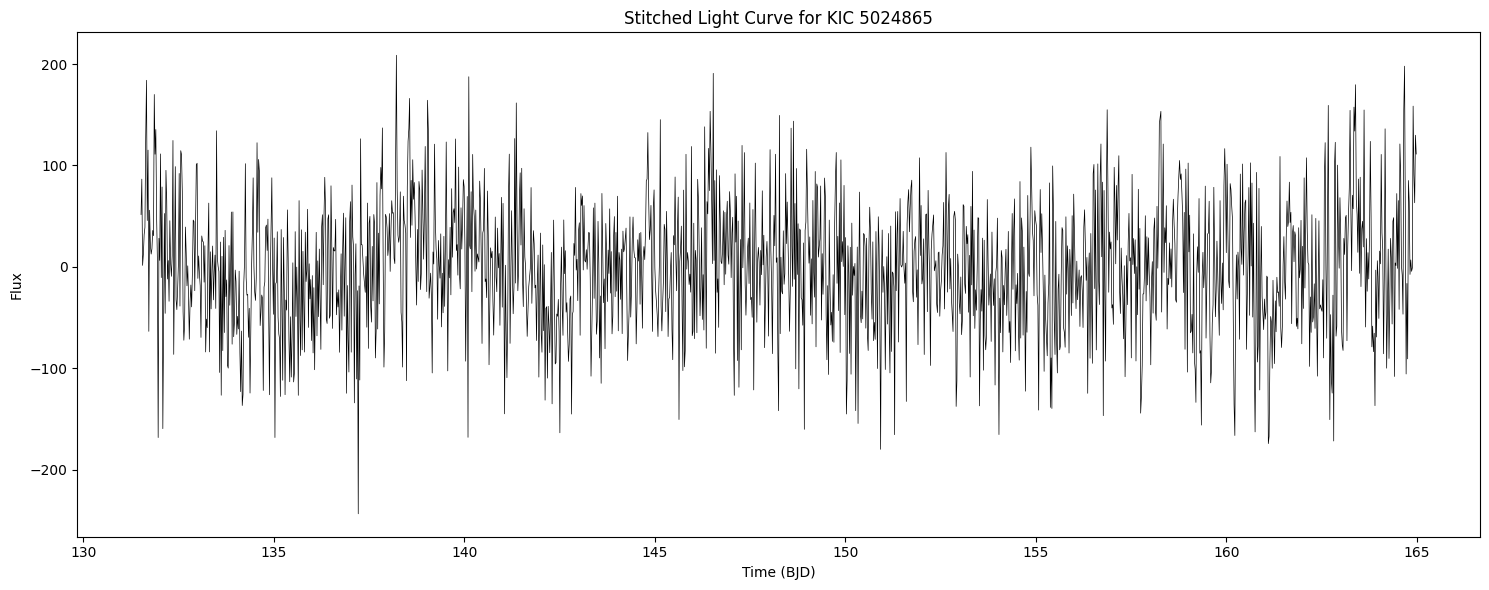

In [219]:
randint = np.random.randint(0,2204)
target_kic = kics[randint]

if target_kic not in all_stars:
    print(f"KIC {target_kic} not found in the dataset")
else:
    star_data = all_stars[target_kic]
    
    times = star_data['times']
    flux = star_data['flux']
    
    plt.figure(figsize=(15, 6))
    
    plt.plot(times, flux, 'k-', linewidth=0.5)
    # plt.scatter(times, flux, s=1, c='blue')
    
    plt.xlabel('Time (BJD)')
    plt.ylabel('Flux')
    plt.title(f'Stitched Light Curve for KIC {target_kic}')
    
    plt.tight_layout()
    plt.show()